In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge
from statsmodels.tools.tools import add_constant


In [104]:
df = pd.read_csv("/content/TN_Enrollment_Awards_Dataset.csv")
df.head()

,Term,Institution,Total Undergraduate Students,Total Graduate Students,Total Students,Total Undergraduate FTE,Total Graduate FTE,Total FTE,FTFTF,Retention Rate,Total Undergraduate Awards,Total Graduate Awards,Total Awards
0,2023,Chattanooga State Community College,7156.0,0.0,7156.0,4485.47,0.0,4485.47,1202.0,0.63,1209.0,0.0,1209.0
1,2023,Cleveland State Community College,3284.0,0.0,3284.0,2096.80,0.0,2096.80,687.0,0.55,1165.0,0.0,1165.0
2,2023,Columbia State Community College,5301.0,0.0,5301.0,3525.87,0.0,3525.87,1169.0,0.63,962.0,0.0,962.0
3,2023,Dyersburg State Community College,3203.0,0.0,3203.0,1866.60,0.0,1866.60,458.0,0.61,800.0,0.0,800.0
4,2023,Jackson State Community College,3224.0,0.0,3224.0,2119.07,0.0,2119.07,612.0,0.55,666.0,0.0,666.0


In [105]:
df = df.drop(columns=["Institution"])

In [106]:
x = df[['Term', 'Total Undergraduate Students', 'Total Graduate Students',
       'Total Undergraduate FTE', 'Total Graduate FTE', 'FTFTF',
       'Retention Rate']]
y = df['Total Awards']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.25, random_state=1856932)

model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rs = model.score(x_train, y_train)

print(f"R-Squared: {rs}")
print(f"Intercept:  {model.intercept_}")
print(f"Slope {model.coef_}")
print(f"MSE: {mse}")

R-Squared: 0.9739408726924339
Intercept:  2142.2839271254597
Slope [  43.04752844   34.6420685  -185.38312494 1666.31880823  540.1009201
 -371.79050546  -85.82944434]
MSE: 110911.19312070437


In [107]:
x_with_const = add_constant(x)

vif_df = pd.DataFrame()
vif_df["Feature"] = x_with_const.columns
vif_df["VIF"] = [variance_inflation_factor(x_with_const.values, i) for i in range(x_with_const.shape[1])]

print(vif_df)

                        Feature           VIF
0                         const  1.444747e+06
1                          Term  1.031413e+00
2  Total Undergraduate Students  7.346014e+01
3       Total Graduate Students  8.970896e+01
4       Total Undergraduate FTE  1.394850e+02
5            Total Graduate FTE  8.157824e+01
6                         FTFTF  1.238411e+01
7                Retention Rate  5.713527e+00


In [108]:
alpha_range = np.logspace(-3, 3, 200)
ridge_cv = RidgeCV(alphas=alpha_range, store_cv_results=True)
ridge_cv.fit(x_train, y_train)

y_pred = ridge_cv.predict(x_test)
print("R-squared:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R-squared: 0.9536606682036795
MSE: 108341.62998869075


In [109]:
coefficients = pd.Series(ridge_cv.coef_, index=['Term', 'Total Undergraduate Students', 'Total Graduate Students',
       'Total Undergraduate FTE', 'Total Graduate FTE', 'FTFTF',
       'Retention Rate'])
print("\nOptimized Ridge Coefficients:")
print(coefficients.sort_values(ascending=False))


Optimized Ridge Coefficients:
Total Undergraduate FTE         1452.540984
Total Graduate FTE               490.624611
Total Undergraduate Students     162.261832
Term                              40.969579
Retention Rate                   -61.172283
Total Graduate Students          -93.707889
FTFTF                           -338.185760
dtype: float64


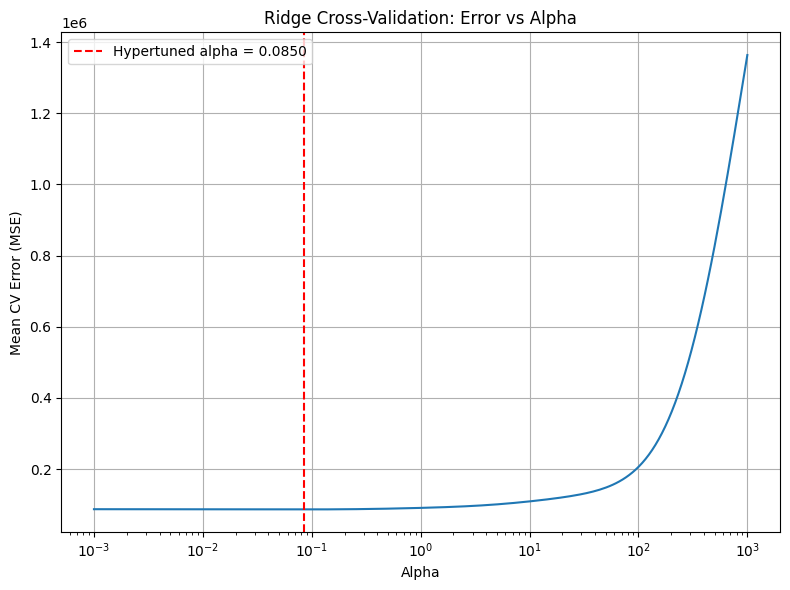

In [110]:
mean_cv_errors = np.mean(ridge_cv.cv_results_, axis=0)

plt.figure(figsize=(8, 6))
plt.plot(ridge_cv.alphas, mean_cv_errors)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean CV Error (MSE)')
plt.title('Ridge Cross-Validation: Error vs Alpha')
plt.axvline(ridge_cv.alpha_, color='red', linestyle='--', label=f'Hypertuned alpha = {ridge_cv.alpha_:.4f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

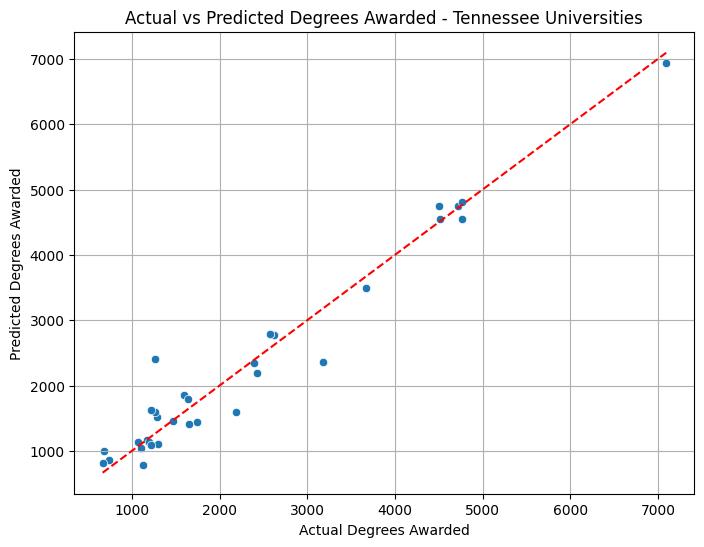

In [111]:
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Degrees Awarded')
plt.ylabel('Predicted Degrees Awarded')
plt.title('Actual vs Predicted Degrees Awarded - Tennessee Universities')
plt.grid(True)
plt.show()

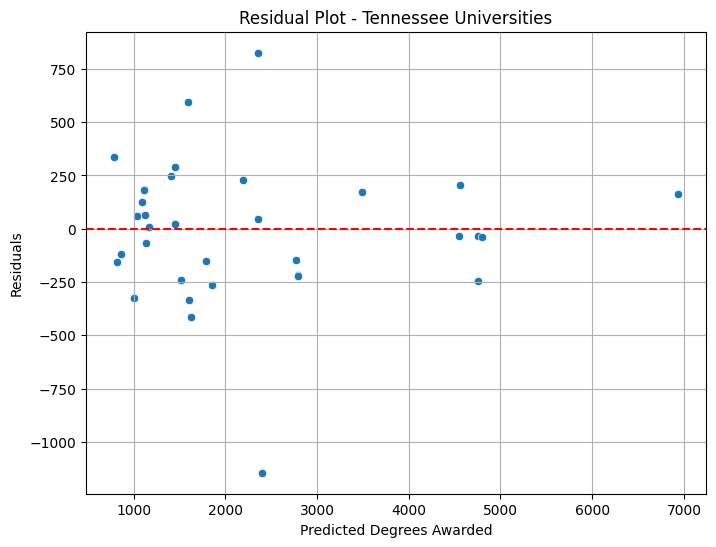

In [112]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted Degrees Awarded')
plt.ylabel('Residuals')
plt.title('Residual Plot - Tennessee Universities')
plt.grid(True)
plt.show()

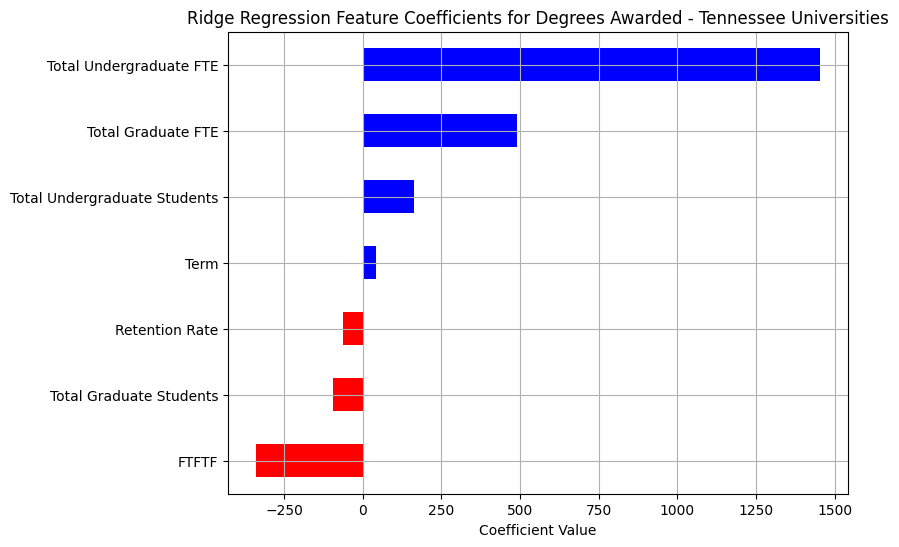

In [113]:
plt.figure(figsize=(8,6))
coefficients.sort_values().plot(kind='barh', color=['red' if val < 0 else 'blue' for val in coefficients.sort_values()])
plt.title('Ridge Regression Feature Coefficients for Degrees Awarded - Tennessee Universities')
plt.xlabel('Coefficient Value')
plt.grid(True)
plt.show()

In [114]:
x = df[['Term', 'Total Awards','FTFTF', 'Retention Rate']]
y = df['Total Students']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.25, random_state=1856932)


model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rs = model.score(x_train, y_train)

print(f"R-Squared: {rs}")
print(f"Intercept:  {model.intercept_}")
print(f"Slope {model.coef_}")
print(f"MSE: {mse}")

R-Squared: 0.9730085948958951
Intercept:  9748.587714650761
Slope [-156.86314807 4956.25827468 1834.82317737  -18.30633409]
MSE: 2185678.2693196083


In [115]:
alpha_range = np.logspace(-3, 3, 200)
ridge_cv = RidgeCV(alphas=alpha_range, store_cv_results=True)
ridge_cv.fit(x_train, y_train)

y_pred = ridge_cv.predict(x_test)
print("R-squared:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R-squared: 0.9482911821416722
MSE: 2185882.5224262686


In [116]:
coefficients = pd.Series(ridge_cv.coef_, index=['Term', 'Total Awards','FTFTF', 'Retention Rate'])
print("\nOptimized Ridge Coefficients:")
print(coefficients.sort_values(ascending=False))


Optimized Ridge Coefficients:
Total Awards      4955.531247
FTFTF             1835.209641
Retention Rate     -17.987011
Term              -156.848927
dtype: float64


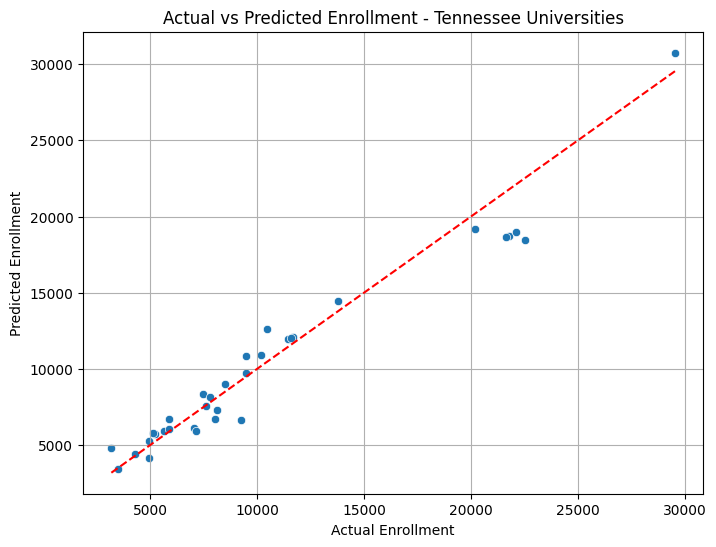

In [117]:
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Enrollment')
plt.ylabel('Predicted Enrollment')
plt.title('Actual vs Predicted Enrollment - Tennessee Universities')
plt.grid(True)
plt.show()

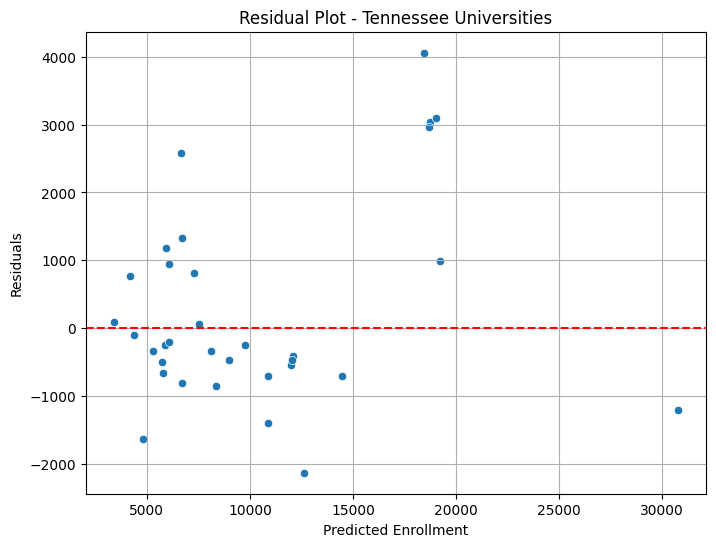

In [118]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted Enrollment')
plt.ylabel('Residuals')
plt.title('Residual Plot - Tennessee Universities')
plt.grid(True)
plt.show()

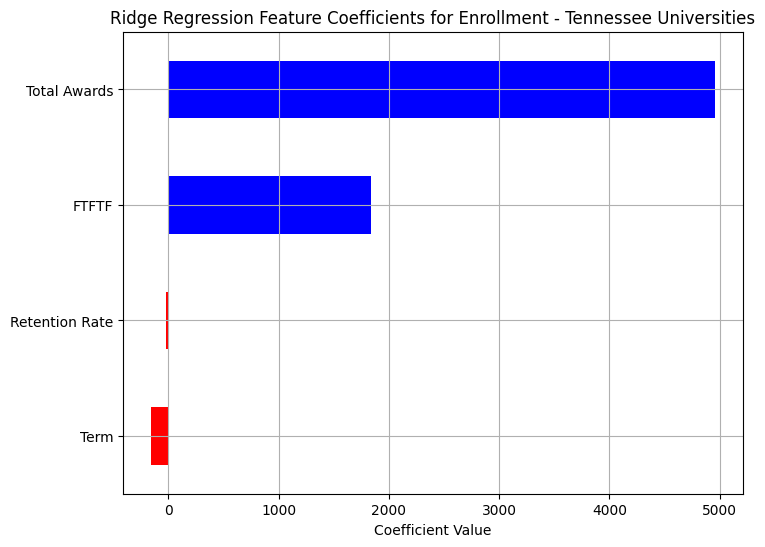

In [119]:
plt.figure(figsize=(8,6))
coefficients.sort_values().plot(kind='barh', color=['red' if val < 0 else 'blue' for val in coefficients.sort_values()])
plt.title('Ridge Regression Feature Coefficients for Enrollment - Tennessee Universities')
plt.xlabel('Coefficient Value')
plt.grid(True)
plt.show()